# 8 聚类方法

给定数据 $x_i\in\mathbb R^p\ (i=1,\dotsc,n)$, 将其 (按照位置关系等) 分为 $k$ 个类, 即为聚类 (clustering).



## 度量

### 距离

可以按照距离关系将 $x_i\ (i=1,\dotsc,n)$ 分类, 距离可以不止是欧氏距离:

#### 闵可夫斯基距离

闵可夫斯基距离 (Minkowski distance): $(m\geqslant 1)$
$$d_{ij} = \Vert x_i - x_j \Vert_m =\left(\sum_{k=1}|x_{ik}  - x_{jk}|^m\right)^\frac 1m$$

特别地, 当 $m = 2$ 是欧氏距离 (Euclidean distance), $m = 1$ 是曼哈顿距离 (Manhattan distance), $m = + \infty$ 是切比雪夫距离 (Chebyshev distance).


#### 马氏距离

马氏距离: $S$ 为正定矩阵,
$$d_{ij} = \Vert x_i - x_j\Vert_{S^{-1}} = \sqrt{(x_i - x_j)^TS^{-1}(x_i - x_j)}$$


### 相似度

除距离外, 可以定义两个数据的相似度, 如余弦相似度或相关系数. 不同的相似度定义往往介于 $[-1,1]$ (或 $[0,1]$) 之间.

#### 余弦相似度

余弦相似度 (cosine similarity) 是两个数据向量的夹角余弦值.

$$s_{ij} = \langle x_i, x_j\rangle = \frac{x_i^Tx_j}{\Vert x_i\Vert_2\Vert x_j\Vert_2}$$

#### 相关系数

相关系数 (correlation coefficient) 将两个数据看成两组 $d$ 个独立同分布观测并计算协方差.
$$r_{ij} = \frac{\sum_{k=1}^p (x_{ik}- \bar x_i)(x_{jk} - \bar x_j)}{\sqrt{\sum_{k=1}^p (x_{ik} - \bar x_i)^2\sum_{k=1}^p (x_{jk} - \bar x_j)^2}}$$

#### 转换

数据越相似, 相似度越大, 距离越小. 可见两个指标是的意义并不相同. 不过可以相互转换. 例如可以定义 $距离 = \sqrt{2(1 - 相似度)}$ 或 $相似度 = (1+距离)^{-1}$.

## 簇

聚类结果分好的每一个类称为簇 / 类 (cluster). 假设 $G$ 是一个簇, 定义其中心为该簇内的数据的平均值:
$$\bar x_G = \frac{1}{|G|}\sum_{x_i\in G}x_i$$

定义其直径为最远的两个数据的距离:
$$D_G = \max_{x_i,x_j\in G}d_{ij}$$

### 簇间距离

两个簇 $G_a, G_b$ 之间的距离, 亦称类连接 (linkage), 可用如下定义衡量:

#### 最短距离

最短距离又称为单连接 (single linkage), 是两个簇之间最近的两个数据的距离:
$$D_{ab} = \min_{x_i\in G_a,\ x_j\in G_b} d_{ij}$$

#### 最长距离

最长距离又称为完全连接 (complete linkage),  是两个簇之间最远的两个数据的距离:
$$D_{ab} =  \max_{x_i\in G_a,\ x_j\in G_b} d_{ij}$$

#### 中心距离

即两个簇的簇中心的距离
$$D_{ab} = d(\bar x_a, \bar x_b)$$

#### 平均距离

即两个簇数据点的距离的平均值
$$D_{ab} = \frac{1}{|G_a||G_b|}\sum_{x_i\in G_a}\sum_{x_j\in G_b}d_{ij}$$

## 层次聚类

层次聚类 (hierachical clustering) 每次选择最近两个类融合为一个新类.

层次聚类和 Kruskal 算法的想法相近, 可以用并查集实现.

In [73]:
import numpy as np
def hierachical(data, k, verbose = False):
    """Perform hierachical clustering to form `k` classes."""
    # first compute the distances of all points
    # distance matrix
    distances = []
    for i in range(data.shape[0] - 1):
        for j, d in enumerate(np.linalg.norm(data[i:i+1] - data[i+1:], axis = 1)):
            distances.append((d, i, i+j+1))

    distances = sorted(distances)
    classes = np.arange(data.shape[0]).tolist()
    class_number = data.shape[0]

    def ufs(i):
        if classes[i] == i: return i
        classes[i] = ufs(classes[i])
        return classes[i]

    for d, i, j in distances:
        if ufs(i) != ufs(j):
            # merge two classes
            classes[ufs(i)] = ufs(j)
            class_number -= 1
            if verbose:
                print('Merging (%d, %d) Distance = %.4f'%(i, j, d))
            if class_number <= k:
                break

    # final update
    classes = [ufs(i) for i in range(data.shape[0])]
    return np.array(classes)

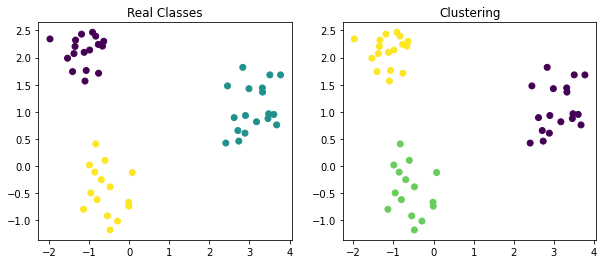

In [77]:
from matplotlib import pyplot as plt

# generate data from Gaussian mixture model
np.random.seed(2022)
n, k = 50, 3     # number of samples and number of Gaussians
gaussian_mean = np.array([[-1,2],[3,1],[-.5,-.5]], dtype = 'float')  # Gaussian parameters
gaussian_vars = np.array([[1,1],[1,1],[1,1]]   , dtype = 'float') / 2.5

real_classes = np.random.randint(3, size = n)
data = np.random.randn(n, 2) * gaussian_vars[real_classes] + gaussian_mean[real_classes]

# use hierachical clustering
pred = hierachical(data, k = k, verbose = False)

plt.figure(figsize =  (10, 4))
for i, c, title in zip((1, 2), (real_classes, pred), ('Real Classes', 'Clustering')):
    plt.subplot(1, 2, i)
    plt.scatter(data.T[0], data.T[1], c = c)
    plt.title(title)
plt.show()

层次聚类很容易被噪声污染, 不好用.

## K-Means

选定 $K$ 个中心点, 将所有数据点分到最近的中心点所在的类, 形成 $K$ 类. 再根据每类的均值更新其对应的中心点. 


如此重复直到分类结果不再变化.

In [80]:
from tqdm import tqdm
import numpy as np

def KMeans(X, k, iter = 6, centers = None):
    """Apply K-means on `X` with shape (N, p) where `k` is number of classes."""
    if centers is None:
        # equispaced initialization
        centers = np.linspace(np.min(X, axis = 0), np.max(X, axis = 0), k + 2)[1:-1]

    # tile X to shape (N, k, p), centers to shape (1, k, p)
    X_ = np.tile(X.reshape((X.shape[0], 1, -1)), [1, k, 1])
    centers = centers.reshape((1, k, -1))
    for i in tqdm(range(iter)):
        # classify to the nearest center
        classes = np.argmin(np.linalg.norm(X_ - centers, axis = -1), axis = 1)

        # update new centers
        for c in range(k):
            same = (classes == c).reshape((-1, 1))
            centers[0, c] = (same * X).sum(axis = 0) / same.sum(axis = 0)
    # print(centers)
    return classes

100%|██████████| 6/6 [00:00<00:00, 1994.12it/s]


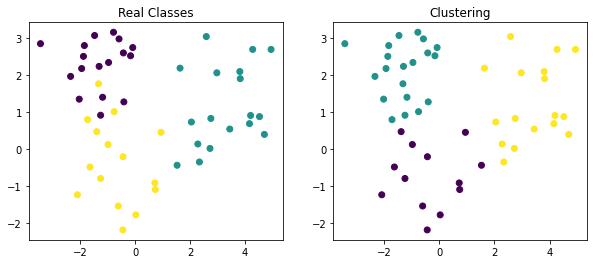

In [85]:
from matplotlib import pyplot as plt

# generate data from Gaussian mixture model
np.random.seed(2022)
n, k = 50, 3     # number of samples and number of Gaussians
gaussian_mean = np.array([[-1,2],[3,1],[-.5,-.5]], dtype = 'float')  # Gaussian parameters
gaussian_vars = np.array([[1,1],[1,1],[1,1]]   , dtype = 'float') 

real_classes = np.random.randint(3, size = n)
data = np.random.randn(n, 2) * gaussian_vars[real_classes] + gaussian_mean[real_classes]

# use K-Means
pred = KMeans(data, k = k)

plt.figure(figsize =  (10, 4))
for i, c, title in zip((1, 2), (real_classes, pred), ('Real Classes', 'Clustering')):
    plt.subplot(1, 2, i)
    plt.scatter(data.T[0], data.T[1], c = c)
    plt.title(title)
plt.show()

In [81]:
from sklearn.datasets import load_iris
data = load_iris()

cluster_result = KMeans(data['data'], k = 3)

acc = (data['target'] == cluster_result).mean()
print('Accuracy of classification by K-means clustering = %.2f%%'%(acc * 100))

100%|██████████| 6/6 [00:00<00:00, 1047.88it/s]

Accuracy of classification by K-means clustering = 89.33%


### 第二类斯特林数

将 $n$ 个样本分为 $m$ 类的分法种数 (不计类的顺序和类内元素的顺序, 允许某类的元素个数为 0) 为第二类斯特林数:
$$S(n,m) = \frac{1}{m!}\sum_{k=0}^m C_m^k (m - k)^n (-1)^k$$

**证明** 对于 $n$ 的任何有序分拆 $n = n_1+\dotsc+n_m,\ n_i\in\mathbb N$, 对应的分法有 $\frac{n!}{n_1!\dotsm n_m!}$ 种, 因此 $m!S(n,m)$ (乘 $m!$ 是为了考虑类的顺序轮换) 是以下母函数的 $n$ 次方项系数
$$n!\left(1+\frac{x}{1!}+\frac{x^2}{2!}+\dotsc\right)^m = n!(e^x - 1)^m$$

所以用留数定理得到:

$$m!S(n,m) = \frac{n!}{2\pi i}\int_{|z|=1}\frac{(e^z - 1)^m}{z^{n+1}}dz
=\frac{n!}{2\pi i}\int_{|z|=1}\sum_{k=0}^mC_m^k\frac{e^{(m-k)z}(-1)^m}{z^{n+1}}dz
=\sum_{k=0}^m C_m^k{(m-k)^n(-1)^m}$$